In [ ]:

import numpy as np

import gymnasium as gym  # Correct way to import Gymnasium
from gymnasium.spaces import Dict, Discrete, Box
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.constants import DIR_TO_VEC
from minigrid.core.grid import Grid
from minigrid.core.actions import Actions
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
from gymnasium.utils.play import play
from gymnasium import ObservationWrapper, spaces
from minigrid.wrappers import FullyObsWrapper
import pandas as pd
# Visualization imports
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.special import logsumexp


import os, glob
import pickle
from pathlib import Path

import sys


from moviepy import VideoFileClip, TextClip, CompositeVideoClip
from moviepy import ImageSequenceClip

import random
SEED = 42
np.random.seed(SEED)
import random
random.seed(SEED)

the state definition includes memory in terms of action, but the feat vector includes the memory of the x mem and y mem of the previous state if there was one

This is the memory-term included maxent irl run through, and it can get demos that were created from 'data_feature_extraction'

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'

In [3]:
%matplotlib inline

In [4]:
%store -r museum_mask_03m

In [5]:
mask = museum_mask_03m
mask = np.flipud(mask)

In [6]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(37, 69))

traces from museum

In [7]:
%store -r museum_df

In [8]:
#downsampled and cleaned df, using instantaneous speed computation and thresholding at 1.5 m/s
%store -r museum_df_cleaned

In [9]:
#additional colum with action taken at previous state, based on state transitions
%store -r museum_df_w_actions

In [10]:
#museum df with memory column added and cleaned for speed and downsampled
%store -r museum_df_w_mem_cleaned

In [11]:
museum_df_w_mem_cleaned

,file,time,x,y,state,visibility,memory
0,cluster_001.csv,"[0.0, 0.0003780718336483932, 0.000945179584120...","[0.6086956521739131, 0.6231884057971014, 0.623...","[0.6756756756756757, 0.6756756756756757, 0.675...","[0.20857988165680474, 0.20931952662721892, 0.2...","[11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, ..."
1,cluster_002.csv,"[0.0, 3.066638044711583e-05, 6.133276089423166...","[0.8695652173913043, 0.8695652173913043, 0.869...","[0.16216216216216217, 0.16216216216216217, 0.1...","[0.9644970414201184, 0.9644970414201184, 0.964...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,cluster_003.csv,"[0.02491408934707904, 0.02534364261168385, 0.0...","[0.014492753623188406, 0.014492753623188406, 0...","[0.6756756756756757, 0.6756756756756757, 0.675...","[0.17825443786982248, 0.17825443786982248, 0.1...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, ...","[0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,cluster_004.csv,"[0.0, 0.0004803073967339097, 0.003362151777137...","[0.07246376811594203, 0.07246376811594203, 0.0...","[0.7027027027027027, 0.7027027027027027, 0.702...","[0.14127218934911243, 0.14127218934911243, 0.1...","[10, 10, 10, 10, 9, 9, 10, 10, 10, 10, 10, 10,...","[0, 0, 0, 0, 4, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, ..."
4,cluster_007.csv,"[0.007297433316557625, 0.008555611474584801, 0...","[0.014492753623188406, 0.014492753623188406, 0...","[0.7027027027027027, 0.7027027027027027, 0.702...","[0.13831360946745563, 0.13831360946745563, 0.1...","[7, 7, 7, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,cluster_009.csv,"[0.0019734987313222443, 0.0026783197067944743,...","[0.014492753623188406, 0.014492753623188406, 0...","[0.7567567567567568, 0.7567567567567568, 0.756...","[0.058431952662721894, 0.058431952662721894, 0...","[8, 8, 8, 7, 7, 7, 9, 8, 8, 8, 8, 10, 10, 10, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,cluster_012.csv,"[0.001634827888952802, 0.001725651660561291, 0...","[0.014492753623188406, 0.014492753623188406, 0...","[0.6486486486486487, 0.6216216216216216, 0.621...","[0.21819526627218935, 0.2581360946745562, 0.25...","[7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, ...","[0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, ..."
7,cluster_017.csv,"[0.012419006479481642, 0.012778977681785457, 0...","[0.014492753623188406, 0.014492753623188406, 0...","[0.7567567567567568, 0.7567567567567568, 0.756...","[0.058431952662721894, 0.058431952662721894, 0...","[8, 8, 8, 8, 8, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,cluster_018.csv,"[0.011353232008789599, 0.011719465299395715, 0...","[0.014492753623188406, 0.014492753623188406, 0...","[0.6486486486486487, 0.6486486486486487, 0.648...","[0.21819526627218935, 0.21819526627218935, 0.2...","[7, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,cluster_021.csv,"[0.00866113316492241, 0.009022013713460845, 0....","[0.014492753623188406, 0.014492753623188406, 0...","[0.7027027027027027, 0.7027027027027027, 0.702...","[0.13831360946745563, 0.13831360946745563, 0.1...","[7, 7, 7, 7, 7, 7, 7, 9, 9, 9, 9, 10, 10, 10, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, ..."


In [51]:
def select_files_by_index(museum_df, index_list):
    """
    Return subset of museum_df corresponding to selected indexes.

    Parameters
    ----------
    museum_df : pd.DataFrame
        DataFrame with columns ['file', 'time', 'x', 'y', 'state', 'visibility']. and others
    index_list : list of int
        List of row indexes to select.

    Returns
    -------
    pd.DataFrame
        Subset of museum_df containing only rows at the given indexes.
    """
    # Ensure indexes are valid and unique
    index_list = sorted(set(index_list))
    selected_df = museum_df.loc[index_list].reset_index(drop=True)
    return selected_df

# 03 2
# 04 3
# 27 12

In [108]:
selected_rows = select_files_by_index(museum_df_w_mem_cleaned, [2, 3, 12])

In [109]:
selected_rows 

,file,time,x,y,state,visibility,memory
0,cluster_003.csv,"[0.02491408934707904, 0.02534364261168385, 0.0...","[0.014492753623188406, 0.014492753623188406, 0...","[0.6756756756756757, 0.6756756756756757, 0.675...","[0.17825443786982248, 0.17825443786982248, 0.1...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, ...","[0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,cluster_004.csv,"[0.0, 0.0004803073967339097, 0.003362151777137...","[0.07246376811594203, 0.07246376811594203, 0.0...","[0.7027027027027027, 0.7027027027027027, 0.702...","[0.14127218934911243, 0.14127218934911243, 0.1...","[10, 10, 10, 10, 9, 9, 10, 10, 10, 10, 10, 10,...","[0, 0, 0, 0, 4, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, ..."
2,cluster_027.csv,"[0.023601604909133822, 0.02383762095822516, 0....","[0.014492753623188406, 0.014492753623188406, 0...","[0.7027027027027027, 0.6756756756756757, 0.675...","[0.13831360946745563, 0.17825443786982248, 0.1...","[7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 8, 8, 9, ...","[0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, ..."


# Define Environment

In [12]:

class SimpleEnv(MiniGridEnv):
    def __init__(
            self, 
            agent_start_pos=(1, 30), # bottom left entrance ( 1, 30) top right corner (63, 5)
            agent_start_dir=0, 
            max_steps=50,
            mask = None, 
            reward_mask = None,
            
            **kwargs,
    ):
        
    
        height, width = mask.shape
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir
        self.agent_dir = 0 #facing up always
        # self.goal_pos = (30, 15)
        self.mask = mask
        self.reward_mask = reward_mask
        self.visited_reward_0 = set()  # holds (x, y) tuples

        
        
        
        mission_space = MissionSpace(mission_func=self._gen_mission)

        super().__init__(
            mission_space=mission_space,
            # grid_size=max(width, height),
            width=width,
            height=height,
            max_steps=max_steps,
            **kwargs,
        )

        # Restore correct values
        self.width = width
        self.height = height

        self.action_space = gym.spaces.Discrete(5)
    @staticmethod
    def _gen_mission():
        return "Museum"

    def _gen_grid(self, width, height):

        self.grid = Grid(self.width, self.height)

        for y in range(self.mask.shape[0]):
            for x in range(self.mask.shape[1]):
                if not self.mask[y, x]:
                    self.grid.set(x, y, Wall())



        #place goal
        # self.put_obj(Goal(), 30, 15)

        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos #check this
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "Museum"

        # print(f"agent_start = {self.agent_start_pos}")
        print(f"[DEBUG] Initialized grid {self.width}x{self.height}, agent at {self.agent_pos}")

    def step(self, action):
        terminated = False
        truncated = False
        x, y = map(int, self.agent_pos)
   

        # Define absolute movement
        if action == 0:      # stay
            dx, dy = 0, 0
        elif action == 1:    # up
            dx, dy = 0, -1
        elif action == 2:    # down
            dx, dy = 0, 1
        elif action == 3:    # left
            dx, dy = -1, 0
        elif action == 4:    # right
            dx, dy = 1, 0
        else:
            raise ValueError(f"Invalid action: {action}")

        new_x, new_y = int(x + dx), int(y + dy)

        # Stay in bounds
        if not (0 <= new_x < self.width and 0 <= new_y < self.height):
            new_x, new_y = x, y

        # Check for wall
        target_cell = self.grid.get(new_x, new_y)
        if target_cell is not None and not target_cell.can_overlap():
            new_x, new_y = x, y  # can't move into wall

        self.agent_pos = (new_x, new_y)


        reward = 0 # hard coded because reward logic doesn't matter
        obs = self.gen_obs()

        info = {}

        return obs, reward, terminated, truncated, info
    
    
    def count_states(self):
        free_cells = sum(1 for x in range(self.grid.width)
                      for y in range(self.grid.height)
                      if not self.grid.get(x, y)) * 4
        return free_cells 


In [55]:
env = SimpleEnv(render_mode= None, mask = mask, reward_mask= None)
env.reset();

[DEBUG] Initialized grid 69x37, agent at (1, 30)


# Functions for MaxEnt IRL

In [85]:
def make_demos(museum_df, state_map, n_bins=2):
    """
    Build per-trace arrays of features:
      [t, x, y, state_aug, visibility, mem_x, mem_y]

    Augmented state encoding (matches P):
      state_aug = ((base + base_n*bin_idx) * n_actions) + action
    where:
      base     = base (x,y) state id in 0..base_n-1 (NOT normalized)
      bin_idx  = time bin index from t ∈ [0,1]
      action   = action taken to reach this state (0..4)
    """
    n_actions = 5
    base_n = int(state_map.max()) + 1

    df = museum_df
    demos = []

    for trace in range(df.shape[0]):
        # assumes columns: 0:'file', 1:'time', 2:'x', 3:'y', 4:'state', 5:'visibility', 6:'memory'
        T = len(df.iloc[trace, 1])  # 'time' list length
        rows = []
        for i in range(T):
            t   = df.iloc[trace, 1][i]   # normalized [0,1]
            x   = df.iloc[trace, 2][i]
            y   = df.iloc[trace, 3][i]
            base = int(df.iloc[trace, 4][i])   # <-- MUST be the base (x,y) ID, not normalized
            vis = df.iloc[trace, 5][i]
            a   = int(df.iloc[trace, 6][i])    # action id 0..4

            # time bin index
            bin_idx = min(max(int(t * n_bins), 0), n_bins - 1)

            # augmented state (matches your build_transition_model encoding)
            state_aug = ((base + base_n * bin_idx) * n_actions) + a

            # memory coordinates:
            # Use the ACTUAL previous (x,y) from the trajectory to avoid unit mismatch
            # (subtracting +/-1 grid step from meter/normalized coords is inconsistent)
            if i > 0:
                mem_x = df.iloc[trace, 2][i-1]
                mem_y = df.iloc[trace, 3][i-1]
            else:
                mem_x, mem_y = x, y

            rows.append([t, x, y, state_aug, vis, mem_x, mem_y])

        demos.append(np.array(rows, dtype=float))

    return demos

In [110]:
# trying selected rows
museum_df = selected_rows

In [90]:
museum_df = museum_df_w_mem_cleaned 

In [111]:
demos = make_demos(museum_df, state_map)

In [100]:
demos[1].shape

(29476, 7)

In [101]:
np.isnan(demos[1]).sum()

np.int64(0)

In [117]:
museum_df

,file,time,x,y,state,visibility,memory
0,cluster_003.csv,"[0.02491408934707904, 0.02534364261168385, 0.0...","[0.014492753623188406, 0.014492753623188406, 0...","[0.6756756756756757, 0.6756756756756757, 0.675...","[0.17825443786982248, 0.17825443786982248, 0.1...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, ...","[0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,cluster_004.csv,"[0.0, 0.0004803073967339097, 0.003362151777137...","[0.07246376811594203, 0.07246376811594203, 0.0...","[0.7027027027027027, 0.7027027027027027, 0.702...","[0.14127218934911243, 0.14127218934911243, 0.1...","[10, 10, 10, 10, 9, 9, 10, 10, 10, 10, 10, 10,...","[0, 0, 0, 0, 4, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, ..."
2,cluster_027.csv,"[0.023601604909133822, 0.02383762095822516, 0....","[0.014492753623188406, 0.014492753623188406, 0...","[0.7027027027027027, 0.6756756756756757, 0.675...","[0.13831360946745563, 0.17825443786982248, 0.1...","[7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 8, 8, 9, ...","[0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, ..."


In [26]:
# state transition logic
def action_selection(demos_list):
    """
    Extract action sequences from demos following MiniGrid (0,0 top-left).
    
    Actions:
        0 = stay
        1 = up    (dy = -1)
        2 = down  (dy = +1)
        3 = left  (dx = -1)
        4 = right (dx = +1)
    """
    def get_actions_from_demo(demo):
        actions = []
        for i in range(len(demo) - 1):
            t, x, y, state, vis = demo[i]
            t_n, x_n, y_n, state_n, vis_n = demo[i + 1]

            if (x == x_n) and (y == y_n):
                action = 0
            elif (x == x_n) and (y_n == y - 1):  # up
                action = 1
            elif (x == x_n) and (y_n == y + 1):  # down
                action = 2
            elif (x_n == x - 1) and (y == y_n):  # left
                action = 3
            elif (x_n == x + 1) and (y == y_n):  # right
                action = 4
            else:
                raise ValueError(f"Invalid transition: {(x, y)} -> {(x_n, y_n)}")

            actions.append(action)
        return np.array(actions)

    if len(demos_list) == 1:
        print("Single demo actions:")
        return get_actions_from_demo(demos_list[0])
    else:
        all_demos_actions = [get_actions_from_demo(demo) for demo in demos_list]
        print("Multiple demo actions")
        return all_demos_actions


               

In [27]:
def action_selection(demos_list):
    """
    Extract action sequences from demos with 8-direction moves.
    
    Actions:
        0 = stay
        1 = up        (dx=0,  dy=-1)
        2 = down      (dx=0,  dy=+1)
        3 = left      (dx=-1, dy=0)
        4 = right     (dx=+1, dy=0)
        5 = up-left   (dx=-1, dy=-1)
        6 = up-right  (dx=+1, dy=-1)
        7 = down-left (dx=-1, dy=+1)
        8 = down-right(dx=+1, dy=+1)
    """
    def get_actions_from_demo(demo):
        actions = []
        for i in range(len(demo) - 1):
            _, x, y, *_ = demo[i]
            _, x_n, y_n, *_ = demo[i + 1]

            dx, dy = int(x_n - x), int(y_n - y)

            if   (dx, dy) == (0, 0):  action = 0
            elif (dx, dy) == (0,-1):  action = 1
            elif (dx, dy) == (0, 1):  action = 2
            elif (dx, dy) == (-1,0):  action = 3
            elif (dx, dy) == ( 1,0):  action = 4
            elif (dx, dy) == (-1,-1): action = 5
            elif (dx, dy) == ( 1,-1): action = 6
            elif (dx, dy) == (-1, 1): action = 7
            elif (dx, dy) == ( 1, 1): action = 8
            else:
                raise ValueError(f"Invalid transition: {(x, y)} -> {(x_n, y_n)}")

            actions.append(action)
        return np.array(actions)

    if len(demos_list) == 1:
        return get_actions_from_demo(demos_list[0])
    else:
        return [get_actions_from_demo(demo) for demo in demos_list]

In [19]:
actions = action_selection(demos)

In [56]:
#visibility
visibility_df = pd.read_csv('/Users/iuliarusu/Documents/museum/drop_model_movement/walkable_positions_with_visibility.csv')
# x = visibility.iloc[:, 1].values  
# y = visibility.iloc[:, 2].values  
c = visibility_df.iloc[:, 3].values 

In [57]:
%store -r state_map

In [58]:
state_map

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], shape=(37, 69))

In [16]:
def check_state_consistency(state_map, P, df):
    for _, row in df.iterrows():
        for sid, x, y in zip(row['state'], row['x'], row['y']):
            # (x,y) from your dataframe
            df_coord = (x, y)

            # (x,y) from raw state_map lookup
            coords_from_map = np.argwhere(state_map == sid)[0][::-1]  # (x,y) order
            map_coord = tuple(coords_from_map)

            if df_coord != map_coord:
                print(f"Mismatch for state {sid}: df={df_coord}, map={map_coord}")

In [17]:
def map_states_from_P(state_map, use_minigrid_coords=True):
    """
    Build a dictionary mapping state_id -> (x, y) coordinates
    consistent with how P was built.
    """
    if use_minigrid_coords:
        canonical_map = np.flipud(state_map).T  # shape = (W, H)
    else:
        canonical_map = state_map               # shape = (H, W)

    lookup = {}

    if use_minigrid_coords:
        W, H = canonical_map.shape
        for x in range(W):
            for y in range(H):
                s = canonical_map[x, y]
                if s >= 0:
                    lookup[int(s)] = (x, y)
    else:
        H, W = canonical_map.shape
        for y in range(H):
            for x in range(W):
                s = canonical_map[y, x]
                if s >= 0:
                    lookup[int(s)] = (x, y)

    return lookup


In [23]:
state_map.shape[0]

37

In [18]:
state_map.max()

np.int64(1351)

plot expert features, per time bin. plot trajectories 
    -adjust binsize accoringly 
- bin peopel's trahectories according to precent of space explored ( split museum space 4)
test with much lower horizon, agent explores space quicker than humans
if maxent, why do we see deterministic policies arise(ask chat)
thoughts on how to modify feature vectors 

In [ ]:

### functions for my actual code ###
### state is now defined as state+time bin + action taken to reach that state ###

def state_to_feature_w_coords(state, state_map, c, nbins=2, add_interactions=False):
    """
    Feature for an augmented state:
      s = ((base + base_n*bin) * n_actions) + a_prev
    Returns [t_binned, coords(2*nbins), state_norm, visibility, x_mem, y_mem]
      - coords puts (x_norm, y_norm) into the slot for this bin, zeros elsewhere
      - x_mem, y_mem are previous-position coords inferred from a_prev
    """

    # ----- constants & geometry -----
    n_actions = 5  # {0:stay,1:up,2:down,3:left,4:right}
    base_n = state_map.max() + 1

    flipped = np.flipud(state_map).T          # index grid as [x, y]
    W, H = flipped.shape                      # NOTE: geometry from flipped, not state_map.T

    # ----- decode augmented state -> (base, bin, a_prev) -----
    a_prev  = int(state % n_actions)
    block   = int(state // n_actions)
    bin_idx = int(block // base_n)
    base_id = int(block %  base_n)

    # clamp bin to [0, nbins-1] just in case
    if bin_idx < 0: bin_idx = 0
    if bin_idx >= nbins: bin_idx = nbins - 1

    # ----- locate current (x, y) cell from base_id -----
    # (Assumes each base_id appears exactly once in 'flipped')
    where = np.where(flipped == base_id)
    if where[0].size == 0:
        raise ValueError(f"base_id {base_id} not found in state_map (check labeling).")
    x = int(where[0][0])
    y = int(where[1][0])

    # normalize current coords
    x_norm = x / W
    y_norm = y / H

    # visibility for this base cell
    visibility = float(c[base_id]) if 0 <= base_id < len(c) else np.nan

    # time bin center in [0,1]
    t_binned = (bin_idx + 0.5) / nbins

    # ----- previous-position (x_mem, y_mem) from a_prev -----
    # id -> (dx, dy)
    id2delta = {
        0: ( 0,  0),  # stay
        1: ( 0, -1),  # up
        2: ( 0,  1),  # down
        3: (-1,  0),  # left
        4: ( 1,  0),  # right
    }
    dx_prev, dy_prev = id2delta.get(a_prev, (0, 0))

    px, py = x - dx_prev, y - dy_prev  # step back from current by a_prev

    # keep previous within bounds & walkable; else fallback to current
    if not (0 <= px < W and 0 <= py < H) or flipped[px, py] == -1:
        px, py = x, y

    x_mem = px / W
    y_mem = py / H

    # ----- assemble features -----
    # coords per bin: put (x_norm, y_norm) into the active bin slot
    coords = np.zeros(2 * nbins, dtype=float)
    coords[2 * bin_idx]     = x_norm
    coords[2 * bin_idx + 1] = y_norm

    # normalize the augmented state id
    nstates_total = base_n * nbins * n_actions
    state_norm = state / nstates_total

    feat_list = [t_binned, *coords, state_norm, visibility, x_mem, y_mem]

    if add_interactions:
        feat_list += [
            t_binned * x_norm,
            t_binned * y_norm,
            t_binned * visibility
        ]

    return np.asarray(feat_list, dtype=float)



def collect_expert_features_w_coords(demos, state_map, nbins=2, add_interactions=False):
    """
    Collect average expert features using augmented state encoding:
        s = ((base + base_n*bin) * n_actions) + a_prev

    For each step, builds features:
        [t_binned, coords_by_bin (2*nbins), state_norm, visibility, x_mem, y_mem]
    where:
      - coords_by_bin puts (x_norm, y_norm) only in the active bin slot, zeros elsewhere
      - (x_mem, y_mem) is inferred from a_prev (previous action), not from demo x/y
    Returns the mean feature vector across all trajectories and timesteps.
    """

    # constants / geometry
    n_actions = 5  # {0:stay, 1:up, 2:down, 3:left, 4:right}
    base_n    = state_map.max() + 1

    flipped = np.flipud(state_map).T
    W, H = flipped.shape

    # action id -> (dx, dy)
    id2delta = {
        0: ( 0,  0),  # stay
        1: ( 0, -1),  # up
        2: ( 0,  1),  # down
        3: (-1,  0),  # left
        4: ( 1,  0),  # right
    }

    nstates_total = base_n * nbins * n_actions

    feat_sums = []
    for traj in demos:
        # we’ll size fsum after building the first feature for this traj
        fsum = None

        for step in traj:
            # Accept (t, x, y, state, vis) or (t, x, y, state, vis, mem_x, mem_y)
            # but we only need t, state, vis here
            if len(step) < 5:
                raise ValueError("Each demo step must have at least (t, x, y, state, visibility).")
            t, _, _, state_aug, visibility = step[:5]

            # ---- decode augmented state -> (base_id, bin_idx, a_prev) ----
            a_prev  = int(state_aug % n_actions)
            block   = int(state_aug // n_actions)
            bin_idx = int(block // base_n)
            base_id = int(block %  base_n)

            # clamp bin
            if bin_idx < 0: bin_idx = 0
            if bin_idx >= nbins: bin_idx = nbins - 1

            # ---- locate (x,y) cell from base_id ----
            where = np.where(flipped == base_id)
            if where[0].size == 0:
                # If your state_map isn't densely labeled 0..base_n-1, build a lookup once.
                raise ValueError(f"base_id {base_id} not found in state_map.")
            x = int(where[0][0])
            y = int(where[1][0])

            x_norm = x / W
            y_norm = y / H

            # ---- previous position from a_prev (one step back) ----
            dx_prev, dy_prev = id2delta.get(a_prev, (0, 0))
            px, py = x - dx_prev, y - dy_prev
            if not (0 <= px < W and 0 <= py < H) or flipped[px, py] == -1:
                px, py = x, y  # fallback to current if invalid
            x_mem = px / W
            y_mem = py / H

            # ---- time-bin feature ----
            t_binned = (bin_idx + 0.5) / nbins

            # ---- coords by bin (2*nbins) ----
            coords = np.zeros(2 * nbins, dtype=float)
            coords[2 * bin_idx]     = x_norm
            coords[2 * bin_idx + 1] = y_norm

            # ---- normalized state id ----
            state_norm = state_aug / nstates_total

            # ---- assemble feature ----
            feat_list = [t_binned, *coords, state_norm, visibility, x_mem, y_mem]
            if add_interactions:
                feat_list += [
                    t_binned * x_norm,
                    t_binned * y_norm,
                    t_binned * visibility,
                ]
            feat = np.asarray(feat_list, dtype=float)

            if fsum is None:
                fsum = np.zeros_like(feat)
            fsum += feat

        if fsum is None:
            # empty trajectory; skip
            continue
        feat_sums.append(fsum)

    if not feat_sums:
        # no data
        return np.zeros(2 * nbins + 5 + (3 if add_interactions else 0), dtype=float)

    # average over trajectories (sum over steps already inside each fsum)
    return np.mean(np.stack(feat_sums, axis=0), axis=0)



#------------------
# Calculate P for env
# ____________________

def build_transition_model(state_map, n_bins=2, horizon=4326):
    action_deltas = {
        0: (0, 0),    # stay
        1: (0, -1),   # up
        2: (0,  1),   # down
        3: (-1, 0),   # left
        4: (1,  0),   # right
    }
    P = {}
    n_actions = len(action_deltas)

    flipped = np.flipud(state_map).T         # ← use this consistently
    W, H = flipped.shape

    base_n = state_map.max() + 1

    # helper to encode augmented state (bin, base) + action
    def encode(base_id, bin_idx, a_prev):
        return ((base_id + base_n * bin_idx) * n_actions) + a_prev

    n_steps   = float(horizon)
    p_leaving = n_bins / n_steps
    p_staying = 1.0 - p_leaving

    for bin in range(n_bins):
        for y in range(state_map.shape[0]):
            for x in range(state_map.shape[1]):
                base = flipped[x, y]               # ← base (x,y) state id
                if base == -1:
                    continue

                for action in action_deltas.keys():  # this is a_prev (the block we’re in)
                    s = encode(base, bin, action)    # current augmented state
                    P[s] = {}

                    for a, (dx, dy) in action_deltas.items():  # a = current action
                        nx, ny = x + dx, y + dy

                        # compute next base id (stay in place if invalid/wall)
                        if nx < 0 or nx >= W or ny < 0 or ny >= H:
                            s_next = base                   # ← BASE id
                        else:
                            nb = flipped[nx, ny]
                            s_next = base if nb == -1 else nb

                        if bin == n_bins - 1:
                            # end bin: no advance; keep bin, set a_prev := a
                            s_stay = encode(s_next, bin, a)
                            P[s][a] = [(1.0, s_stay, 0.0, False)]
                        else:
                            # two outcomes: same bin vs next bin (a_prev := a in both)
                            s_stay    = encode(s_next, bin,     a)
                            s_advance = encode(s_next, bin + 1, a)
                            P[s][a] = [
                                (p_staying, s_stay,    0.0, False),
                                (p_leaving, s_advance, 0.0, False),
                            ]
    return P



def soft_value_iteration_temp(P, rewards, gamma=0.99, tau=1.0, eps=1e-4, max_iter=10000):
    """
    Soft value iteration with temperature tau.
    P[s][a] -> list of (prob, s_next, r_env, done)
    rewards: np.ndarray (n_states,), state-only reward r(s) by default.
    inv tau: same thing as beta in Tishbi's work.
    Raising tau decreases beta -> smooth policy
    """
    n_states = len(P)
    n_actions = max(len(P[s]) for s in range(n_states))

    V = np.zeros(n_states, dtype=float)
    inv_tau = 1.0 / max(tau, 1e-12)

    for _ in range(max_iter):
        V_prev = V.copy()

        # Compute Q(s,a) under current V_prev
        Q = np.full((n_states, n_actions), -np.inf, dtype=float)
        for s in range(n_states):
            for a in range(n_actions):
                if a not in P[s]:
                    continue
                q = 0.0
                for prob, s_next, r_env, done in P[s][a]:
                    # If using state-only rewards, keep rewards[s]; otherwise use r_env or rewards[s_next]
                    r_sa = rewards[s]  # or: r_env
                    q += prob * (r_sa + (0.0 if done else gamma * V_prev[s_next]))
                Q[s, a] = q

        # Soft Bellman backup with temperature
        V = tau * logsumexp(Q * inv_tau, axis=1)

        if np.max(np.abs(V - V_prev)) < eps:
            break

    # Soft policy: π(a|s) = softmax(Q(s,·)/tau)
    logits = Q * inv_tau
    logits -= logits.max(axis=1, keepdims=True)        # stabilize
    pi = np.exp(logits)
    pi /= pi.sum(axis=1, keepdims=True)

    return V, pi


    


# -------------------------
# Compute feature expectations under policy
# -------------------------

def compute_policy_feature_expectations(P, c, policy, state_map, n_bins=2, n_rollouts=50, horizon=4326):
    feats = []
    n_actions = policy.shape[1]

    for _ in range(n_rollouts):
        s = 0 #np.random.choice(list(P.keys()))  # start from random state, can switch later
        fsum = np.zeros_like(state_to_feature_w_coords(s, state_map, c, n_bins, add_interactions= False))  # t = 0

        for t in range(horizon):
            # add features for current state
            fsum += state_to_feature_w_coords(s, state_map, c, n_bins, add_interactions=False)

            # sample action from policy
            a = np.random.choice(n_actions, p=policy[s])

            # sample next state from P[s][a]
            transitions = P[s][a]
            probs, next_states = zip(*[(prob, ns) for prob, ns, _, _ in transitions])
            s = np.random.choice(next_states, p=probs)

        feats.append(fsum)

    return np.mean(feats, axis=0)




def maxent_irl(P, demos, state_map, c, state_to_feature, n_bins = 2, horizon = 4326, lr=0.1, n_iters=50, gamma=0.99):
    """
    Maximum Entropy IRL training loop.

    Parameters
    ----------
    P : dict
        Transition model: P[s][a] = [(prob, next_state, reward, done)]
    demos : list
        List of expert demos (each a list of features or states).
    state_map : np.ndarray
        State map (height, width) with state IDs.
    c : np.ndarray
        Visibility array indexed by state ID.
    state_to_feature : function
        Function mapping (state, t, state_map, c) -> feature vector.
    lr : float
        Learning rate for gradient ascent.
    n_iters : int
        Number of gradient iterations.
    gamma : float
        Discount factor for value iteration.

    Returns
    -------
    theta : np.ndarray
        Learned reward weights.
    rewards : np.ndarray
        Final reward function over states.
    policy : np.ndarray
        Final policy (n_states × n_actions).
    """
   
    # --- Step 1: Expert feature expectations ---
    # expert_feats = []
    # for demo in demos:
    #     # demo is already [t, x, y, state, visibility]
    #     fsum = np.sum([np.array([t, x, y, s, vis], dtype=float)
    #                    for (t, x, y, s, vis) in demo], axis=0)
    #     expert_feats.append(fsum)
    # expert_mu = np.mean(expert_feats, axis=0)

    expert_mu = collect_expert_features_w_coords(demos, state_map, nbins=2, add_interactions=False)

    n_states = (state_map.max() + 1) * n_bins * 5  # 5 actions
    n_features = len(state_to_feature_w_coords(0, state_map, c, n_bins, add_interactions=False))
    theta = np.random.randn(n_features)

    # --- Step 2: IRL loop ---
    for it in range(n_iters):
        # Compute reward for each state
        rewards = np.zeros(n_states) #rewards 
        for s in range(n_states):
            # feats = state_to_feature(s, state_map, c, n_bins)
            feats = state_to_feature_w_coords(s, state_map, c, nbins=2, add_interactions=False)
            rewards[s] = np.dot(theta, feats) #currently doesn't take time into account
            

        # Soft value iteration → policy
        print( "starting svp")
        V, policy = soft_value_iteration_temp(P, rewards, gamma=gamma, tau=2.0, eps=1e-4)

        # Policy feature expectations
        print("starting compute policy feature expectations")
        mu_pi = compute_policy_feature_expectations(P, c, policy, state_map, n_bins)

        # Gradient update
        grad = expert_mu - mu_pi
        theta += lr * grad

        print("expert_mu:", expert_mu)
        print("mu_pi:", mu_pi)
        print(f"Iter {it}: ||grad||={np.linalg.norm(grad):.3f}")

    return theta, rewards, policy



In [112]:
P = build_transition_model(state_map)

# testing maxent irl

In [113]:
theta, rewards, policy = maxent_irl(P, demos, state_map, c, state_to_feature_w_coords, lr=0.00005, n_iters=50)

starting svp
starting compute policy feature expectations
expert_mu: [1038.33333333   14.80193237  828.10810811   15.13043478  846.48648649]
mu_pi: [2142.7         397.97797101  716.48378378  387.1515942   683.16108108]
Iter 0: ||grad||=12092.775
starting svp
starting compute policy feature expectations
expert_mu: [1038.33333333   14.80193237  828.10810811   15.13043478  846.48648649]
mu_pi: [2207.13        373.25942029  674.33783784  409.73449275  724.02324324]
Iter 1: ||grad||=12042.388
starting svp
starting compute policy feature expectations
expert_mu: [1038.33333333   14.80193237  828.10810811   15.13043478  846.48648649]
mu_pi: [2303.51        335.98927536  611.92486486  442.75768116  785.21675676]
Iter 2: ||grad||=11904.452
starting svp
starting compute policy feature expectations
expert_mu: [1038.33333333   14.80193237  828.10810811   15.13043478  846.48648649]
mu_pi: [2239.31        350.47652174  648.11405405  413.51188406  735.66756757]
Iter 3: ||grad||=11028.479
starting svp

# plot features per bin

In [129]:
def plot_expert_features(demos, state_map, museum_df, n_bins=4):
    """
    Plot expert feature expectations (x, y) per time bin.
    """

    W,H = state_map.T.shape

   # same bin logic as before
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # colormap for clusters
    cluster_files = museum_df["file"].tolist()
    n_clusters = len(cluster_files)
    colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))

    # collect and plot per bin
    binned_xy = {b: [] for b in range(n_bins)}

    # iterate through demos (same index as rows of museum_df)
    for cluster_idx, traj in enumerate(demos):
        for (t, x, y, state, visibility) in traj:
            # assign to bin
            bin_idx = np.digitize(t, bin_edges, right=False) - 1
            bin_idx = np.clip(bin_idx, 0, n_bins - 1)
            t_binned = bin_centers[bin_idx]
            binned_xy[bin_idx].append((x, y, cluster_idx))

    # plot per bin
    for b in range(n_bins):
        plt.figure(figsize=(6, 5))
        plt.title(f'Expert Feature Expectations - Bin {b}')
        plt.xlabel('X (normalized)')
        plt.ylabel('Y (normalized)')

        if len(binned_xy[b]) == 0:
            plt.text(0.5, 0.5, 'No data for this bin', ha='center', va='center')
            plt.axis('off')
            plt.show()
            continue

        xs = [p[0] for p in binned_xy[b]]
        ys = [p[1] for p in binned_xy[b]]
        cidx = [p[2] for p in binned_xy[b]]

        for cluster_idx in np.unique(cidx):
            mask = np.array(cidx) == cluster_idx
            plt.scatter(
                np.array(xs)[mask],
                np.array(ys)[mask],
                s=10,
                color=colors[cluster_idx % len(colors)],
                alpha=0.7,
                label=cluster_files[cluster_idx].replace(".csv", "")
            )

        plt.legend(markerscale=2, fontsize=8)
        plt.tight_layout()
        plt.show()

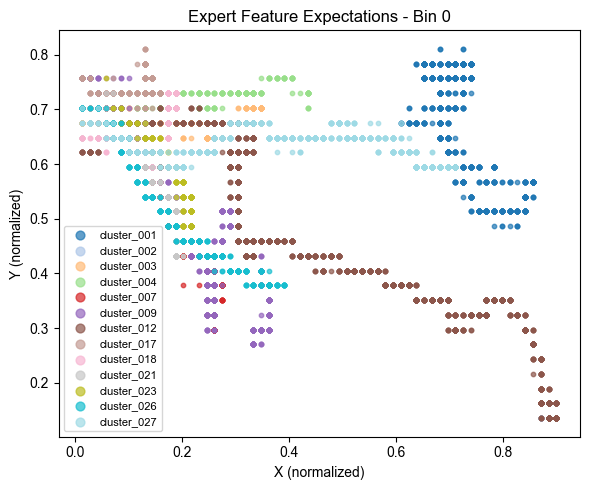

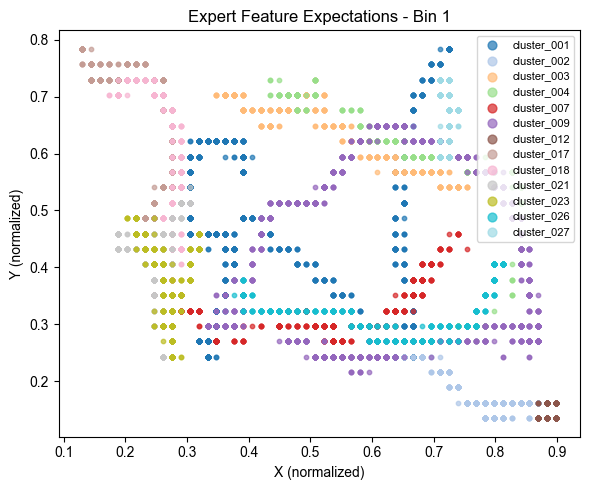

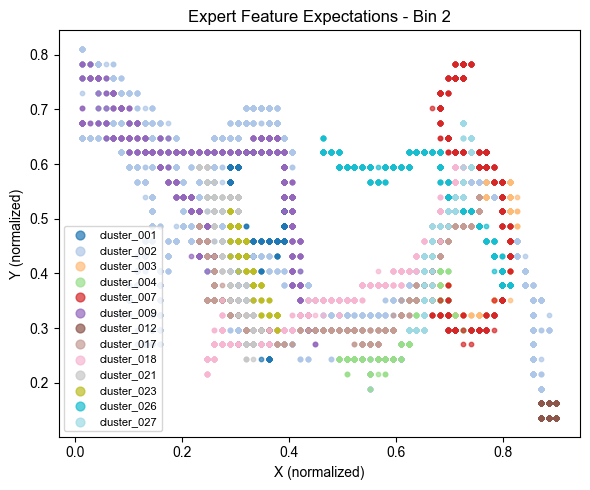

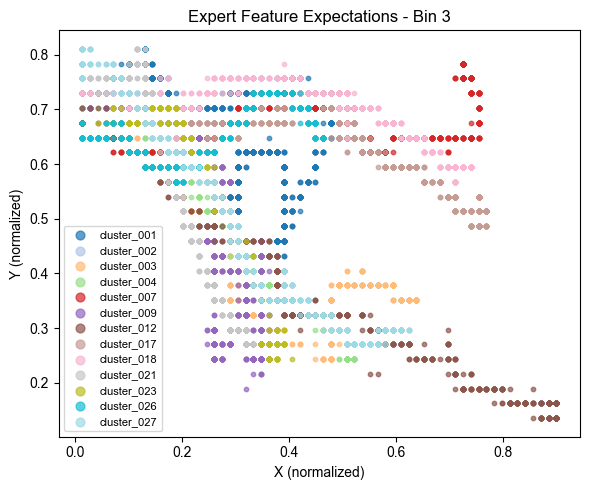

In [130]:
plot_expert_features(demos, state_map, museum_df, n_bins=4)

In [29]:
def plot_cluster_features(museum_df, demos, state_map, cluster_idx,  n_bins=4):
    """
    Plot all (x, y) features for a single cluster (trajectory),
    showing points from all time bins together.

    cluster_idx: index of the cluster/row in museum_df.
    """
    W,H = state_map.T.shape
    
    # setup
    cluster_name = museum_df.iloc[cluster_idx]["file"]
    traj = demos[cluster_idx]
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    xs, ys, colors = [], [], []

    # compute t_binned for each point and store
    for (t, x, y, state, visibility) in traj:
        bin_idx = np.digitize(t, bin_edges, right=False) - 1
        bin_idx = np.clip(bin_idx, 0, n_bins - 1)
        t_binned = bin_centers[bin_idx]
        # store normalized coordinates and bin index for coloring
        xs.append(x * W)
        ys.append(y * H)
        colors.append(bin_idx)  # color by bin

    # plot all bins together, color-coded by bin index
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(xs, ys, c=colors, cmap="viridis", s=12, alpha=0.8)
    # Overlay the -1 regions from state_map
    obstacles = np.where(np.flipud(state_map) == -1)
    plt.scatter(obstacles[1], obstacles[0], color="lightgray", s=10, alpha=0.6, label="Walls")
    plt.gca().invert_yaxis()
    # plt.colorbar(scatter, label="Time bin")
    cbar = plt.colorbar(scatter, label="Time bin")
    cbar.set_ticks(np.unique(colors)) 
    plt.xlabel("X (normalized)")
    plt.ylabel("Y (normalized)")
    plt.title(f"All Features for {cluster_name}")
    plt.tight_layout()
    plt.show()

listing similar features
starts from bottom, 4 seperate areas
csv  idx
03 2
04 3
27 12


split but opposite, start up, finish down
07 4
18 8
26 11

short scale start up, finish down
21 9
23 10



In [228]:
museum_df

,file,time,x,y,state,visibility
0,cluster_001.csv,"[0.0, 9.45179584120983e-05, 0.0001890359168241...","[0.6086956521739131, 0.6086956521739131, 0.608...","[0.6756756756756757, 0.6756756756756757, 0.675...","[0.20857988165680474, 0.20857988165680474, 0.2...","[11, 11, 11, 12, 12, 12, 11, 11, 12, 12, 12, 1..."
1,cluster_002.csv,"[0.0, 3.066638044711583e-05, 6.133276089423166...","[0.8695652173913043, 0.8695652173913043, 0.869...","[0.16216216216216217, 0.16216216216216217, 0.1...","[0.9644970414201184, 0.9644970414201184, 0.964...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
2,cluster_003.csv,"[0.02491408934707904, 0.02534364261168385, 0.0...","[0.014492753623188406, 0.014492753623188406, 0...","[0.6756756756756757, 0.6756756756756757, 0.675...","[0.17825443786982248, 0.17825443786982248, 0.1...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
3,cluster_004.csv,"[0.0, 0.0004803073967339097, 0.000960614793467...","[0.07246376811594203, 0.07246376811594203, 0.0...","[0.7027027027027027, 0.7027027027027027, 0.702...","[0.14127218934911243, 0.14127218934911243, 0.1...","[10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 9, 9, ..."
4,cluster_007.csv,"[0.007297433316557625, 0.007800704579768495, 0...","[0.014492753623188406, 0.014492753623188406, 0...","[0.7027027027027027, 0.7027027027027027, 0.702...","[0.13831360946745563, 0.13831360946745563, 0.1...","[7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, ..."
5,cluster_009.csv,"[0.0019734987313222443, 0.002537355511700028, ...","[0.014492753623188406, 0.014492753623188406, 0...","[0.7567567567567568, 0.7567567567567568, 0.756...","[0.058431952662721894, 0.058431952662721894, 0...","[8, 8, 8, 8, 8, 8, 7, 8, 7, 7, 7, 7, 7, 7, 7, ..."
6,cluster_012.csv,"[0.001634827888952802, 0.001695377070025128, 0...","[0.014492753623188406, 0.014492753623188406, 0...","[0.6486486486486487, 0.6216216216216216, 0.621...","[0.21819526627218935, 0.2581360946745562, 0.25...","[7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
7,cluster_017.csv,"[0.012419006479481642, 0.01259899208063355, 0....","[0.014492753623188406, 0.014492753623188406, 0...","[0.7567567567567568, 0.7567567567567568, 0.756...","[0.058431952662721894, 0.058431952662721894, 0...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 7, 7, 8, ..."
8,cluster_018.csv,"[0.011353232008789599, 0.011719465299395715, 0...","[0.014492753623188406, 0.014492753623188406, 0...","[0.6486486486486487, 0.6486486486486487, 0.648...","[0.21819526627218935, 0.21819526627218935, 0.2...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, ..."
9,cluster_021.csv,"[0.00866113316492241, 0.009022013713460845, 0....","[0.014492753623188406, 0.014492753623188406, 0...","[0.7027027027027027, 0.7027027027027027, 0.702...","[0.13831360946745563, 0.13831360946745563, 0.1...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, ..."


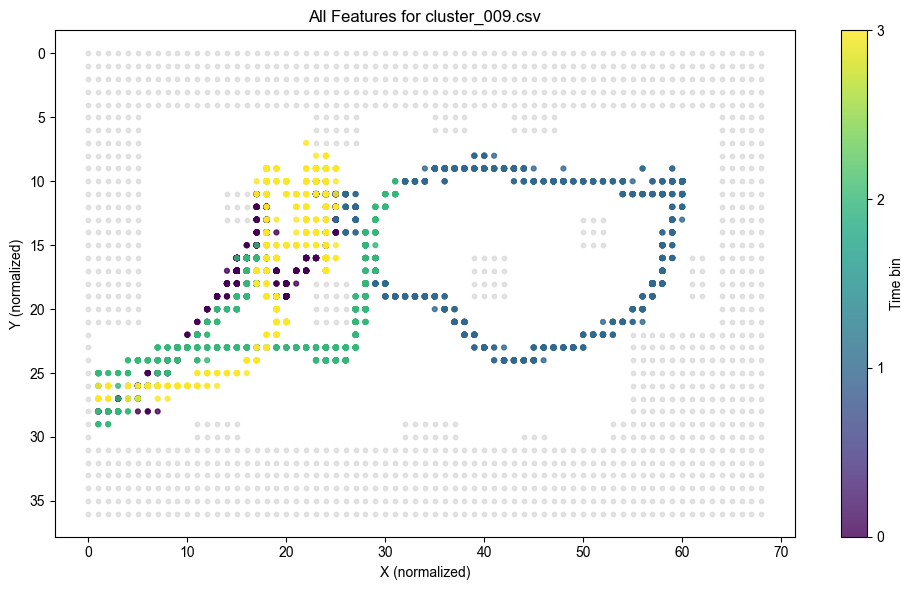

In [273]:
plot_cluster_features(museum_df, demos, state_map,  cluster_idx=5, n_bins=4)

In [ ]:
for i in range(museum_df.shape[0]):
    plot_cluster_features(museum_df, demos, state_map,  cluster_idx=i, n_bins=4)

    


# testing out converstion fxn

In [76]:
def run_policy(env, policy, state_map, step_count):
    """Run the environment using the learned policy from a MaxEnt IRL."""

    env.reset()[0]  # Reset environment
    x, y = env.agent_pos # Convert starting position to index
    current_state = np.flipud(state_map).T[x, y]

    step_count = 0  # Track steps to prevent infinite loops

    while step_count < 1000:  # Prevent infinite loops

        action = np.random.choice(len(policy[current_state]), p=policy[current_state]) # Choose best action, probabilitically
        obs, reward, terminated, truncated, info = env.step(action) 
        ### use rollouts here, grab the true state, if binned, convert to base_n, that is next state  # Take action
        x_t, y_t = env.agent_pos  # x_t y_t change 
        next_state =  np.flipud(state_map).T[x_t, y_t]     # Convert new state
        env.render()  # Visualize movement
        # Calculate info to go term for the current step
        print(f"current state: {current_state}, action: {action}, next state: {next_state}")
        current_state = next_state  # Update current state
        step_count += 1

In [69]:
def run_policy_t(env, policy, state_map, n_bins = 4, horizon=4326):
    """Run the environment using the learned policy from a MaxEnt IRL."""
    #needs base_n, p_leaving, n_bins 

    base_n = state_map.max() + 1
    n_steps = float(horizon)
    p_leaving = 0.01  # probability of leaving current time bin

    env.reset()[0]  # Reset environment
    x, y = env.agent_pos # Convert starting position to index
    t_bin = 0  #initialize time
    current_state = np.flipud(state_map).T[x, y]
    

    step_count = 0  # Track steps to prevent infinite loops

    while step_count < 10000:  # Prevent infinite loops

        action = np.random.choice(len(policy[current_state]), p=policy[current_state]) # Choose best action, probabilitically
        obs, reward, terminated, truncated, info = env.step(action) 
        # if transition to next time bin t_bin += 1
        if t_bin < n_bins-1:
            if np.random.rand() < p_leaving:
                t_bin += 1
        ### use rollouts here, grab the true state, if binned, convert to base_n, that is next state  # Take action
        x_t, y_t = env.agent_pos  # x_t y_t change 
        next_state =  np.flipud(state_map).T[x_t, y_t] + t_bin*base_n     # Convert new state
        env.render()  # Visualize movement
        # Calculate info to go term for the current step
        print(f"current state: {current_state}, action: {action}, next state: {next_state}, step count: {step_count}, time bin: {t_bin}")
        current_state = next_state  # Update current state
        step_count += 1

In [70]:
env = SimpleEnv(render_mode= "human", mask = mask, reward_mask= None)
env.reset();

[DEBUG] Initialized grid 69x37, agent at (1, 30)


In [121]:
policy.shape

(13520, 5)

In [292]:
policy[1793]

array([5.04401846e-01, 3.10724878e-13, 4.95597593e-01, 2.73299248e-07,
       2.87939501e-07])

In [294]:
policy[1739]

array([4.95584092e-01, 5.04388105e-01, 2.66114700e-07, 2.63874730e-07,
       2.72720184e-05])

In [293]:
policy[0]

array([5.85121306e-26, 4.95186573e-01, 5.85121306e-26, 5.85121306e-26,
       5.04813427e-01])

In [122]:
run_policy_t(env, policy, state_map, n_bins = 2, horizon=2704)

[DEBUG] Initialized grid 69x37, agent at (1, 30)
current state: 0, action: 2, next state: 0, step count: 0, time bin: 0
current state: 0, action: 2, next state: 0, step count: 1, time bin: 0
current state: 0, action: 1, next state: 38, step count: 2, time bin: 0
current state: 38, action: 0, next state: 38, step count: 3, time bin: 0
current state: 38, action: 4, next state: 39, step count: 4, time bin: 0
current state: 39, action: 4, next state: 40, step count: 5, time bin: 0
current state: 40, action: 3, next state: 39, step count: 6, time bin: 0
current state: 39, action: 2, next state: 1, step count: 7, time bin: 0
current state: 1, action: 1, next state: 39, step count: 8, time bin: 0
current state: 39, action: 3, next state: 38, step count: 9, time bin: 0
current state: 38, action: 3, next state: 38, step count: 10, time bin: 0
current state: 38, action: 2, next state: 0, step count: 11, time bin: 0
current state: 0, action: 1, next state: 38, step count: 12, time bin: 0
current 

KeyboardInterrupt: 

# plot reward as function of space

In [308]:
%store P

Stored 'P' (dict)


In [119]:

def compute_multi_r(rewards, state_map, n_bins=4):
    """Convert flat rewards to 2D map per bin for visualization."""
    base_n = int(state_map.max()) + 1

    for rewards_bin in range(n_bins):
        # Slice rewards corresponding to this bin
        start = rewards_bin * base_n
        end = (rewards_bin + 1) * base_n
        rewards_slice = rewards[start:end]

        # Create empty 2D reward map
        final_rewards = np.zeros(state_map.T.shape)

        # Fill each spatial location
        for s in range(base_n):
            r = rewards_slice[s]
            x = np.where(np.flipud(state_map).T == s)[0][0]
            y = np.where(np.flipud(state_map).T == s)[1][0]
            final_rewards[x][y] = r

        # Plot
        plt.figure(figsize=(8, 6))
        plt.imshow(final_rewards.T, cmap='coolwarm')
        plt.colorbar(label='Reward', shrink=0.65)
        plt.title(f'Reward Map - Bin {rewards_bin}')
        plt.axis('off')
        plt.show()



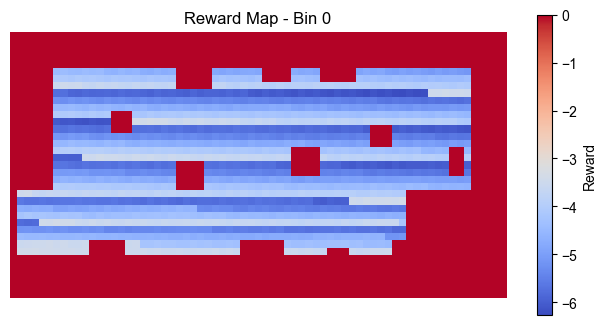

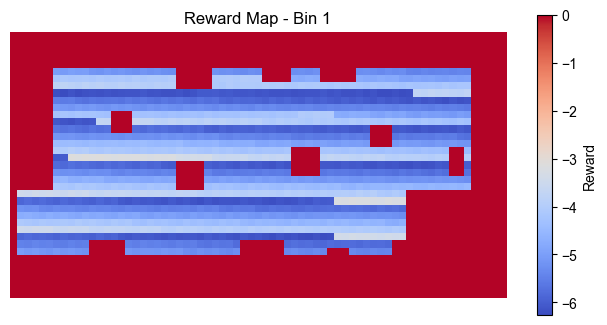

In [120]:
compute_multi_r(rewards, state_map, n_bins=2)

In [304]:
%store rewards

Stored 'rewards' (ndarray)


In [305]:
%store policy

Stored 'policy' (ndarray)


In [37]:

def compute_rewards(theta, state_map, c, state_to_feature):
    """Compute reward for each state given learned weights theta."""
    final_rewards = np.zeros(state_map.T.shape)
    ret_rewards = np.zeros(state_map.T.shape)
    fin_flat = np.zeros(int(state_map.max()) + 1)
    
    for s in range(int(state_map.max()) + 1):
        # t, x, y, state, visbility = state_to_feature(s, 0, state_map, c, horizon)
        # feats = state_to_feature(s, 0, state_map, c, horizon)
        feats = state_to_feature(s, state_map, c, nbins=4)
        r = np.dot(theta, feats)
        x = np.where(np.flipud(state_map).T == s)[0][0]
        y = np.where(np.flipud(state_map).T == s)[1][0]
        final_rewards[x][y] = r
        ret_rewards[x][y] = rewards[s]
        fin_flat[s] = r
    
    return final_rewards, ret_rewards, fin_flat

    
                

In [38]:
final_r, ret_r, fin_flat = compute_rewards(-theta, state_map, c, state_to_feature)

In [46]:
theta

array([10.91691485,  4.96200321,  0.25197934, 16.435996  ,  1.40768327])

In [39]:
final_r[1,30]

np.float64(-11.494617944061508)

ValueError: x and y must be the same size

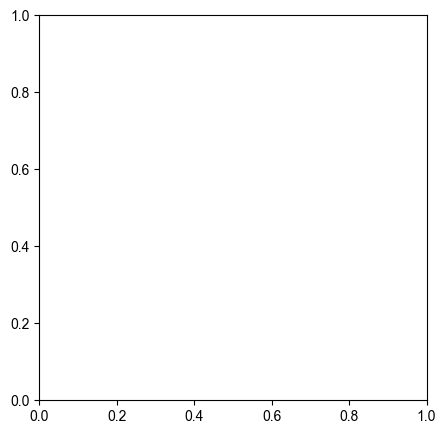

In [40]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(fin_flat, rewards, alpha=0.5)

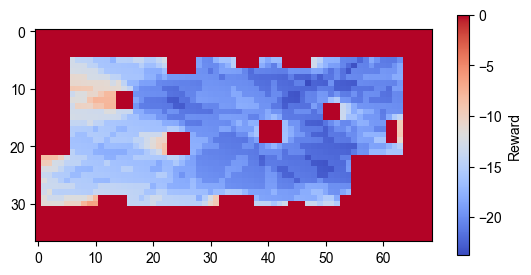

In [43]:
plt.imshow(final_r.T, cmap='coolwarm')
plt.colorbar(label='Reward', shrink=0.65)
# plt.title("Museum Reward Structure from MaxEnt IRL")
# plt.savefig('/Users/iuliarusu/Documents/museum/images/reward_struct.svg', format='svg', bbox_inches='tight')

# Information to Go Terms and Plotting

In [309]:
# P(s)

#get probability of state using time probability
def build_policy_transition_matrix(P, policy):
    """Built s_next by s matrix"""
    n_states = len(P)
    n_actions = policy.shape[1]
    P_pi = np.zeros((n_states, n_states))
    for s in range(n_states):
        for a in range(n_actions):
            for prob, s_next, _, _ in P[s][a]:
                P_pi[s, s_next] += policy[s, a] * prob
    return P_pi


def compute_state_distribution(P, policy, s0, T):
    """Compute state distribution after T steps from s0 under policy."""
    n_states = len(P)
    P_pi = build_policy_transition_matrix(P, policy)
    initial_dist = np.zeros(n_states)
    initial_dist[s0] = 1.0
    P_pi_T = np.linalg.matrix_power(P_pi, T)
    P_s = initial_dist @ P_pi_T
    assert np.isclose(P_s.sum(), 1.0), f"Not normalized: {P_s.sum()}"
    return P_s



In [310]:
# Build P_pi
P_pi = build_policy_transition_matrix(P, policy)

# Distribution after 10 steps starting from state 0
P_s = compute_state_distribution(P, policy, s0=0, T=10)
print(P_s)  # vector of length n_states

[3.79856553e-109 3.38617480e-101 7.39082404e-094 ... 0.00000000e+000
 0.00000000e+000 0.00000000e+000]


In [312]:

def plot_state_distribution(P_s, state_map, title="State distribution"):
    # MiniGrid-style map: (x,y)
    canonical_map = state_map.T          # shape = (W, H)
    W, H = canonical_map.shape

    # Build grid as (H, W): rows=y, cols=x
    grid = np.full((H, W), np.nan, dtype=float)
    for x in range(W):
        for y in range(H):
            s = canonical_map[x, y]
            if s >= 0:
                grid[y, x] = P_s[s]

    plt.figure(figsize=(6, 6))
    # extent ensures axes go 0..W and 0..H; origin='lower' -> (0,0) bottom-left
    plt.imshow(grid, origin="lower", cmap="viridis",
               extent=[0, W, 0, H], interpolation="nearest", aspect="equal")
    plt.colorbar(label="Probability")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(0, W)
    plt.ylim(0, H)
    plt.show()

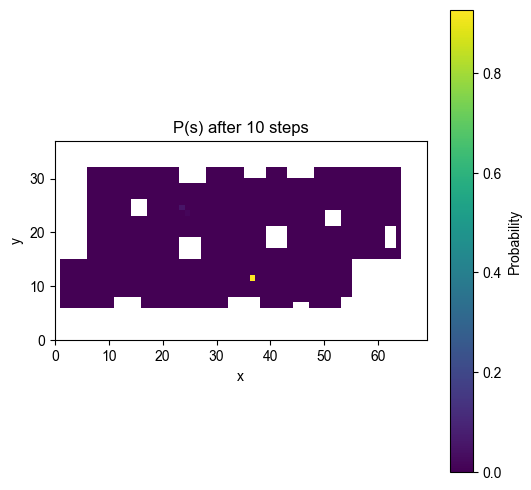

In [313]:
P_s = compute_state_distribution(P, policy, s0=0, T=40)
plot_state_distribution(P_s, state_map, title="P(s) after 10 steps")


In [314]:
def plot_multiple_distributions(P, policy, state_map, s0=0, steps=[10,20,30,40,50]):
    n = len(steps)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 5), sharex=True, sharey=True)

    canonical_map = state_map.T
    W, H = canonical_map.shape

    for ax, T in zip(axes, steps):
        # Compute P(s) after T steps
        P_s = compute_state_distribution(P, policy, s0=s0, T=T)

        # Build grid for plotting
        grid = np.full((H, W), np.nan, dtype=float)
        for x in range(W):
            for y in range(H):
                s = canonical_map[x, y]
                if s >= 0:
                    grid[y, x] = P_s[s]

        # Plot with individual colorbar
        im = ax.imshow(grid, origin="lower", cmap="viridis",
                       extent=[0, W, 0, H], interpolation="nearest", aspect="equal")
        ax.set_title(f"P(s) after {T} steps")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Probability")

    plt.tight_layout()
    plt.show()


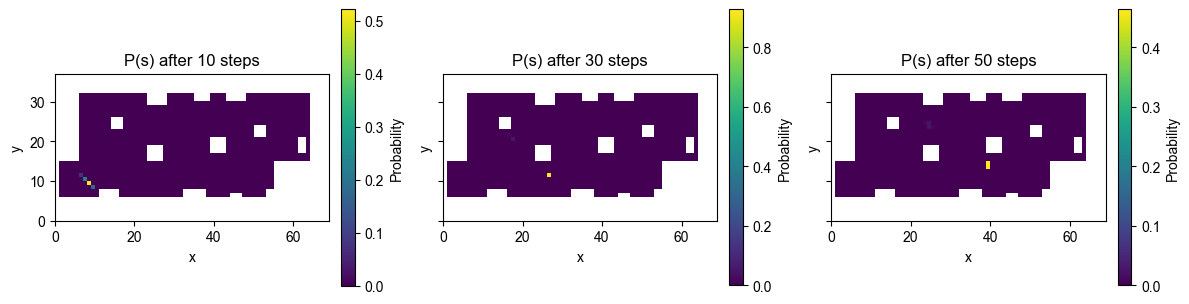

In [315]:
plot_multiple_distributions(P, policy, state_map, s0=0, steps=[10,30,50])


In [316]:
# pi(a)
def get_Pi_a(P, policy, s0, T):
    """
    Compute marginal action distribution π(a) after T steps.
    """
    # State distribution at T
    P_s = compute_state_distribution(P, policy, s0, T)

    # Weighted average of π(a|s) across states
    pi_a = np.sum(P_s[:, None] * policy, axis=0)

    # Normalize (safety)
    pi_a /= pi_a.sum()
    return pi_a

def get_decision(P, policy, s0, T):
    """
    Compute decision terms through time (like relative entropy).
    """
    decisions = []
    for t in range(T):
        # Marginal π(a) at time t
        pi_a = get_Pi_a(P, policy, s0, t)

        decision_terms = []
        for s in P.keys():  # all states
            if np.any(policy[s] > 0):
                decision_term = np.sum(
                    policy[s] * (np.log(policy[s] + 1e-15) - np.log(pi_a + 1e-15))
                )
                decision_terms.append(decision_term)
        decisions.append(decision_terms)
    return decisions

In [317]:
# Example: compute π(a) after 20 steps
pi_a_20 = get_Pi_a(P, policy, s0=0, T=20)
print("π(a) after 20 steps:", pi_a_20)
print("Sum:", pi_a_20.sum())  # should be ~1

π(a) after 20 steps: [7.74627179e-11 4.59895145e-07 7.47470961e-18 1.51358620e-15
 9.99999540e-01]
Sum: 1.0


In [318]:
# Compute π(a) for multiple horizons
steps = [0, 10, 20, 30, 50, 100]
for T in steps:
    pi_a = get_Pi_a(P, policy, s0=0, T=T)
    print(f"T={T}: {pi_a}")

T=0: [1.23383314e-23 4.94475945e-01 1.23383314e-23 1.23383314e-23
 5.05524055e-01]
T=10: [6.83263020e-10 3.51874234e-01 7.12369347e-18 1.51348459e-15
 6.48125765e-01]
T=20: [7.74627179e-11 4.59895145e-07 7.47470961e-18 1.51358620e-15
 9.99999540e-01]
T=30: [1.87657575e-10 5.04979457e-02 6.34835529e-16 1.97137588e-15
 9.49502054e-01]
T=50: [0.49056468 0.24105029 0.24199603 0.01239706 0.01399193]
T=100: [0.48827088 0.23894367 0.23972339 0.01578639 0.01727568]


In [319]:
# Decision terms up to horizon 20
decisions = get_decision(P, policy, s0=0, T=20)

# decisions[t] = list of decision terms (one per state) at time t
print("Decision terms at t=5:", decisions[5][:10])  # first 10 states

Decision terms at t=5: [np.float64(0.10450164577219985), np.float64(0.10450164577219985), np.float64(0.10450164577219985), np.float64(0.10450164577219986), np.float64(0.10450164596278401), np.float64(0.1046116065562489), np.float64(0.10460055703674925), np.float64(34.53154382277549), np.float64(34.5315642824502), np.float64(34.53161269836042)]


In [320]:
def decision_term_map(P, policy, t):
    """
    Compute decision term per state at time t.
    Returns: dict {state: value}
    """
    pi_a = get_Pi_a(P, policy, s0=0, T=t)
    values = {}

    for s in P.keys():
        if np.any(policy[s] > 0):
            values[s] = np.sum(
                policy[s] * (np.log(policy[s] + 1e-15) - np.log(pi_a + 1e-15))
            )
    return values

def plot_decision_map(P, policy, state_map, t, ax=None):
    """
    Plot decision terms over the grid at time t.
    """
    decision_vals = decision_term_map(P, policy, t)
    canonical_map = state_map.T
    W, H = canonical_map.shape

    grid = np.full((H, W), np.nan)
    for x in range(W):
        for y in range(H):
            s = canonical_map[x, y]
            if s in decision_vals:
                grid[y, x] = decision_vals[s]

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(grid, origin="lower", cmap="coolwarm",
                   extent=[0, W, 0, H], interpolation="nearest", aspect="equal")
    ax.set_title(f"Decision terms at t={t}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.colorbar(im, ax=ax, label="Decision term")
    return im

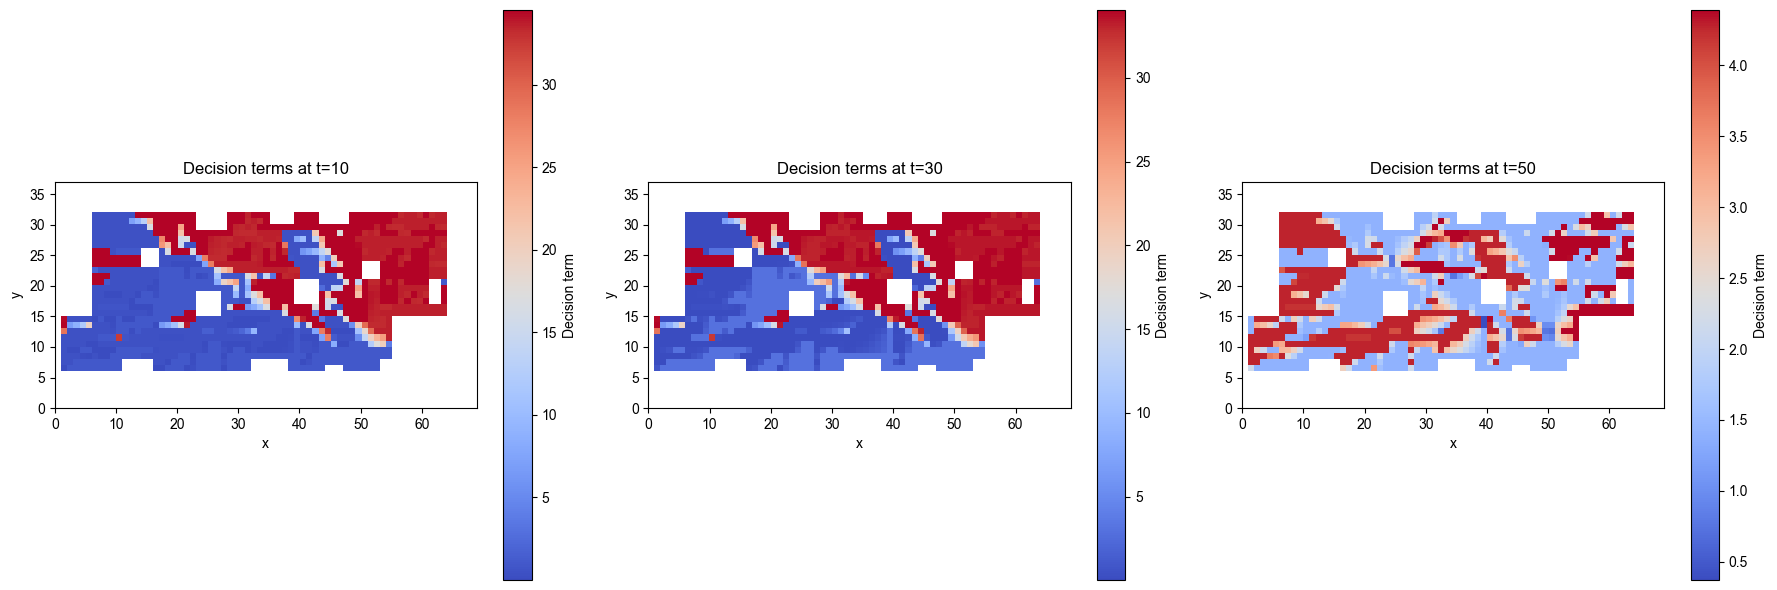

In [321]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
for ax, t in zip(axes, [10, 30, 50]):
    plot_decision_map(P, policy, state_map, t, ax=ax)

plt.tight_layout()
plt.show()

# Videos

In [51]:
def run_and_save(env, policy, state_map, folder="frames", n_steps=300):
    os.makedirs(folder, exist_ok=True)
    obs, _ = env.reset()
    x, y = env.agent_pos
    current_state = np.flipud(state_map).T[x, y]

    for step in range(n_steps):
        # Pick action from policy
        probs = policy[current_state]
        a = np.random.choice(len(probs), p=probs)
        obs, _, done, _, _ = env.step(a)

        # Render frame as numpy array
        frame = env.render()

        # Save frame to disk
        plt.imsave(f"{folder}/frame_{step:04d}.png", frame)

        # Update state
        x, y = env.agent_pos
        current_state = np.flipud(state_map).T[x, y]

        if done:
            break

In [52]:
class QVideo:
    @staticmethod
    def clear_folder(folder_name):
        files = glob.glob(os.path.join(folder_name, "*.png"))
        for f in files:
            os.remove(f)

    @staticmethod
    def create_video_from_images(image_folder, output_file, fps=10):
        """
        Create a video from a sequence of saved PNG frames.
        """
        image_pattern = os.path.join(image_folder, "frame_*.png")
        image_files = sorted(glob.glob(image_pattern))
        clip = ImageSequenceClip(image_files, fps=fps)
        clip.write_videofile(output_file, codec="libx264", audio_codec="aac")

In [53]:
env_v = SimpleEnv(render_mode= "rgb_array", mask = mask, reward_mask= None)
env_v.reset();

[DEBUG] Initialized grid 69x37, agent at (1, 30)


In [55]:
# Step 1: run and save rollout
run_and_save(env_v, policy, state_map, folder="frames", n_steps=300)

# Step 2: stitch into video
QVideo.create_video_from_images("frames", "simulation_time1.mp4", fps=10)


[DEBUG] Initialized grid 69x37, agent at (1, 30)
MoviePy - Building video simulation_time1.mp4.
MoviePy - Writing video simulation_time1.mp4



MoviePy - Done !
MoviePy - video ready simulation_time1.mp4
